In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [2]:
train_gen=tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
    horizontal_flip=False, vertical_flip=False, rescale=None,
    preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None
)

In [3]:
image_size = (100, 100)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=r"./downloads/",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 183 files belonging to 2 classes.
Using 147 files for training.


In [4]:
class_names = ['tulasana', 'vajrasana']

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

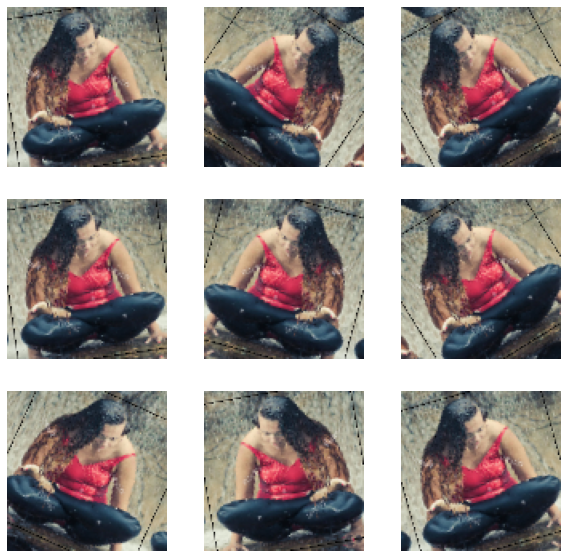

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [7]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [15]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = inputs

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=(100,100) + (3,), num_classes=2)


In [16]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 100, 100, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 50, 50, 32)   896         rescaling_1[0][0]                
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 50, 50, 32)   128         conv2d_6[0][0]                   
_______________________________________________________________________________________

In [17]:
model.summary()


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 100, 100, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 50, 50, 32)   896         rescaling_1[0][0]                
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 50, 50, 32)   128         conv2d_6[0][0]                   
_______________________________________________________________________________________

In [18]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks
)


Epoch 1/10
5/5 [==============================] - 5s 1s/step - loss: 0.5887 - accuracy: 0.7143
Epoch 2/10
5/5 [==============================] - 5s 1s/step - loss: 0.3064 - accuracy: 0.8503
Epoch 3/10
5/5 [==============================] - 5s 1s/step - loss: 0.1679 - accuracy: 0.9524
Epoch 4/10
5/5 [==============================] - 5s 1s/step - loss: 0.1198 - accuracy: 0.9456
Epoch 5/10
5/5 [==============================] - 5s 1s/step - loss: 0.0795 - accuracy: 0.9660
Epoch 6/10
5/5 [==============================] - 5s 1s/step - loss: 0.0243 - accuracy: 1.0000
Epoch 7/10
5/5 [==============================] - 5s 1s/step - loss: 0.0109 - accuracy: 1.0000
Epoch 8/10
5/5 [==============================] - 5s 1s/step - loss: 0.0025 - accuracy: 1.0000
Epoch 9/10
5/5 [==============================] - 6s 1s/step - loss: 0.0063 - accuracy: 1.0000
Epoch 10/10
5/5 [==============================] - 6s 1s/step - loss: 9.4303e-04 - accuracy: 1.0000


In [25]:
img = keras.preprocessing.image.load_img(
    "test1.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent tulasana and %.2f percent vajrasana."
    % (100 * (1 - score), 100 * score)
)

This image is 38.21 percent tulasana and 61.79 percent vajrasana.
